<a href="https://colab.research.google.com/github/youssefhanighazal10/Image-Segmentation/blob/main/Final_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
import random
from sklearn.metrics import f1_score
import sys
import numpy
from sklearn.metrics.cluster import contingency_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import SpectralClustering
from google.colab import data_table
import pandas as pd

In [ ]:
numpy.set_printoptions(threshold=sys.maxsize)
data_table.enable_dataframe_formatter()

In [ ]:
from google.colab import drive
drive.mount('/content/segmentation_dataset')

Drive already mounted at /content/segmentation_dataset; to attempt to forcibly remount, call drive.mount("/content/segmentation_dataset", force_remount=True).


**Functions**

In [ ]:
def normalized_cut(image):
  image = image.reshape(321,481,3)
  image = cv2.resize(image , (100,100))
  image = np.array(image)
  similarity = similarity_knn(image)
  delta = np.sum(similarity,axis =1)
  delta = np.diag(delta)
  L = delta - similarity
  La = np.dot(np.linalg.inv(delta),L)
  eigen_values , eigen_vectors = np.linalg.eigh(La)
  idx = eigen_values.argsort()
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]
  for i in range(0,100*100):
    if(eigen_values[i]>0):
      break
  eigen_vectors_reduced = eigen_vectors[:,i:i+5]
  eigen_vectors_reduced = preprocessing.normalize(eigen_vectors_reduced)
  k = KMeans(n_clusters = 5).fit(eigen_vectors_reduced)
  return k.labels_

In [ ]:
def similarity_knn(image):
  image = image.reshape(10000,3)
  similarity = np.zeros((10000,10000))
  for i in range(0,10000):
    distance = []
    for j in range(0,10000):
      distance.append(np.linalg.norm(image[i]-image[j]))
    distance = np.array(distance)
    idx = distance.argsort()
    idx = np.array(idx)  
    idx  = idx[1:6] 
    similarity[i][idx] = 1
  return similarity

In [ ]:
def kmeans(Data,no_clusters,max_iterations,tolerance):
  centroids = []
  for i in range(no_clusters):
    rgb = np.random.randint(256, size=(3))
    centroids.append(rgb)

  assign = np.empty((len(Data),1))
  counter = 0
  iteration = 0

  while True:
    prev_centroid = centroids.copy()
    # loop over the elements
    for i in range(0,len(Data)):
      min = np.inf

      # calculate the euclidean distance between each element and the centroids
      for j in range(0,no_clusters):
        dist = np.linalg.norm(Data[i] - centroids[j])
        if dist < min:
          min = dist
          index = j

      # check if the element changed his cluster
      if(assign[i] == index):
        counter = counter + 1
      else:
        # assign the element to the new cluster
        assign[i] = index
        
    # check if no changes in assignment happened then stop looping
    if(counter == len(assign)):
      break
    counter = 0
    
    # loop over the clusters
    for j in range(0,no_clusters):
      cluster = np.empty((0,3))

      # calculate the mean of elements from the same cluster
      for i in range(0,len(assign)):
        if(assign[i]==j):
          cluster = np.append(cluster,np.array([Data[i]]),axis=0)
      if (len(cluster)!=0):  
        mean = np.mean(cluster,axis=0)
        centroids[j] = mean
      else :
        centroids[j] = np.random.randint(256, size=(3))


    iteration = iteration + 1
    if(iteration == max_iterations):
       break

    distance = np.subtract(prev_centroid,centroids)
    if(np.linalg.norm(distance) <= tolerance):
      break

  return assign

In [ ]:
def clusters_reduction(groundTruth,k):
  test = groundTruth.copy()
  for i in range(0,5):
    values ,counts = np.unique(test[i],return_counts=True)
    idx = counts.argsort()[::-1]
    idx = np.array(idx)   
    values = values [idx[0:k-1]]  
    for j in range(len(test[i])):
      if (test[i][j] != values[:]).all():
        test[i][j] = k-1
      else:
        test[i][j] = np.where(idx == test[i][j]-1)[0][0] 
  return test

In [ ]:
def sort(array):
  values ,counts = np.unique(array,return_counts=True)
  idx = counts.argsort()[::-1]
  idx = np.array(idx)      
  for j in range(len(array)):
    array[j] = np.where(idx == array[j])[0][0] 
  return array

In [ ]:
def entropyy(groundTruth,labels):
  contingency_mat = contingency_matrix (groundTruth, labels)
  contingency_mat = np.array(contingency_mat)
  print(contingency_mat.shape)
  # rows->true
  count_per_cluster = np.sum(contingency_mat,axis = 1)
  total_count = np.sum(contingency_mat)
  total_entropy  = 0
  for i in range(0,contingency_mat.shape[0]):
    entropy = []
    x = 0
    for j in range(0,contingency_mat.shape[0]):  
      if (contingency_mat[i][j]==0):
        continue
      x += -(contingency_mat[i][j]/count_per_cluster[i])*np.log10(contingency_mat[i][j]/count_per_cluster[i])
    total_entropy += x*(count_per_cluster[i]/total_count)
  return total_entropy

**Import Dataset**

In [ ]:
test_jpg = []
for i in range(1,51):
    image = cv2.imread(f'segmentation_dataset/MyDrive/segmentation_dataset/images/test/test ({i}).jpg') 
    image = image.reshape(321*481,3)
    test_jpg.append(image)

**Import Ground truth**

In [ ]:
n = 321*481
test_mat = []
for i in range(1,51):
  layers = []
  mat = scipy.io.loadmat(f'segmentation_dataset/MyDrive/segmentation_dataset/groundTruth/test/test ({i}).mat')
  con_list = [[element for element in upperElement] for upperElement in mat['groundTruth']]
  con_list = np.array(con_list)
  no_layers = con_list.shape[1]
  con_list = con_list.reshape(con_list.shape[1])
  for j in range(0,5):
    segmentation =con_list[j][0].flatten()
    layers.append(np.array(segmentation))
  test_mat.append(np.array(layers))
test_mat = np.array(test_mat)

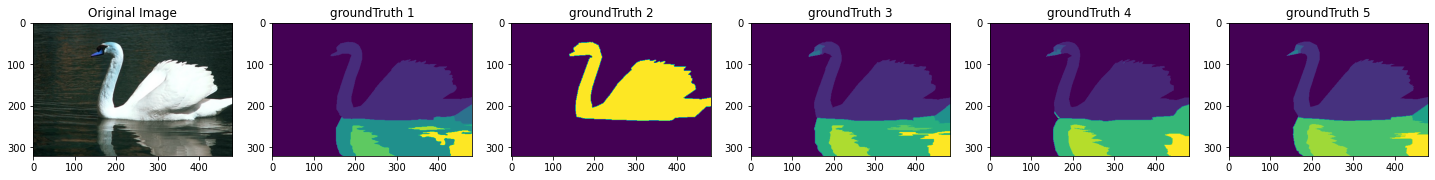

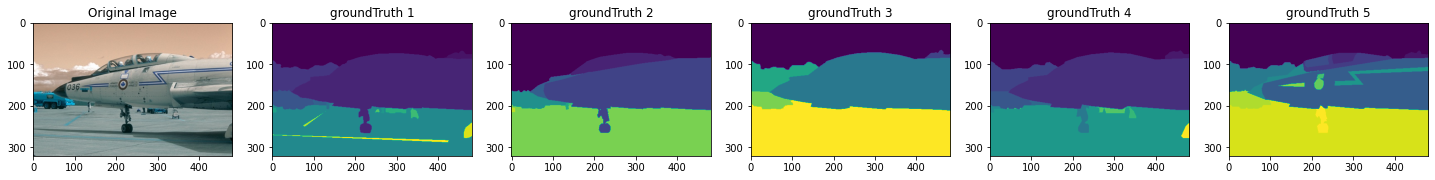

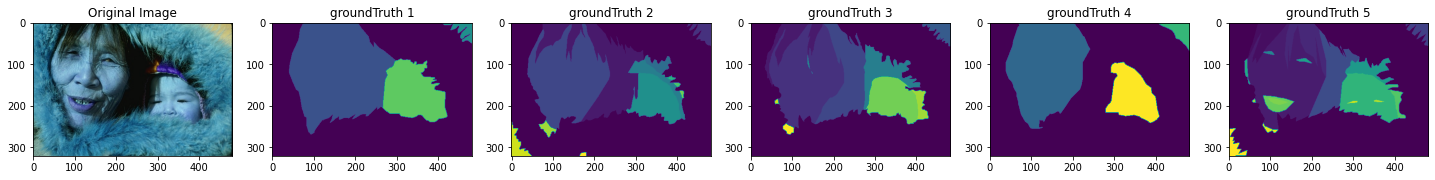

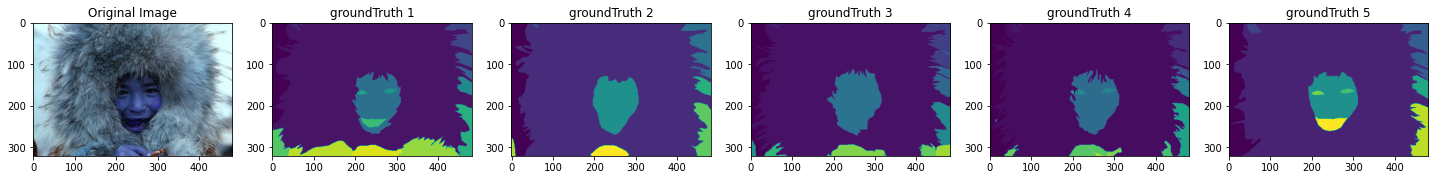

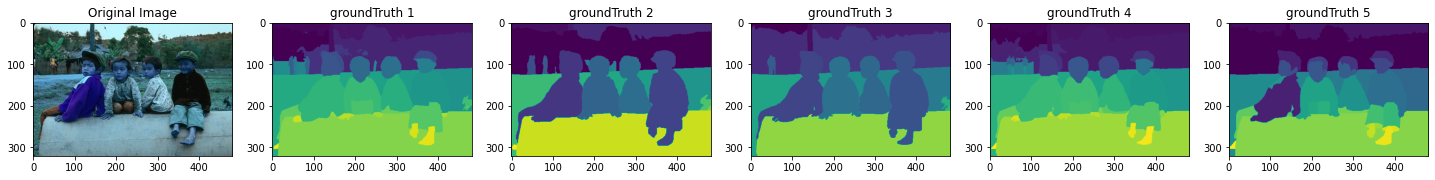

In [ ]:
for i in range(0,5):
  fig, axs = plt.subplots(1,6, figsize=(25,5))
  axs[0].imshow(test_jpg[i+4].reshape(321,481,3))
  axs[0].set_title("Original Image")
  for j in range(1, 6) :
    axs[j].imshow(test_mat[i+4][j-1].reshape(321,481))
    axs[j].set_title("groundTruth "+ str(j))

**K-Means**

In [ ]:
k = [3,5,7,9,11]
output = []
for i in range(0,50):
  labels  = []
  for j in k:
    label =  KMeans(n_clusters = j).fit(test_jpg[i])
    labels.append(label.labels_)
  output.append(labels)

In [ ]:
k = [3,5,7,9,11]
output_implemented = []
for i in range(4,10):
  labels  = []
  for j in k:
    label = kmeans(test_jpg[i],no_clusters=j,max_iterations=5,tolerance=1)
    labels.append(label)
  output_implemented.append(labels)

**Evaluation Measures**

In [ ]:
f_measure = []
entropy = []
for i in range(0,50):
  average_scores = []
  average_entropy = []
  for j in range(0,5):
    scores_fscore = []
    scores_entropy = []
    test = clusters_reduction(test_mat[i],j*2+3)
    output[i][j] = sort(output[i][j])
    for x in range(len(test)):
      test[x] = sort(test[x])
      scores_fscore.append(f1_score(test[x], output[i][j], average='micro'))
      scores_entropy.append(entropyy(test[x], output[i][j]))
    average_scores.append(np.mean(scores_fscore))
    average_entropy.append(np.mean(scores_entropy))
  f_measure.append(average_scores)
  entropy.append(average_entropy)

**F-Measure Results**

In [ ]:
f1 = np.array(f_measure)
f1 = pd.DataFrame(f1, columns=['k = 3','k = 5','k = 7','k = 9','k = 11'])
f1.style.set_caption("F-Measure")
display(f1)

k = 3     k = 5     k = 7     k = 9    k = 11
0   0.239691  0.165007  0.091428  0.083145  0.079216
1   0.393799  0.273814  0.293155  0.256949  0.194777
2   0.335502  0.178382  0.099437  0.080637  0.073413
3   0.322596  0.194771  0.096552  0.239962  0.072336
4   0.866304  0.348213  0.303424  0.271860  0.211768
5   0.288721  0.465641  0.427869  0.394026  0.306067
6   0.450782  0.327067  0.277358  0.183569  0.136859
7   0.441327  0.308188  0.219728  0.155522  0.133006
8   0.581283  0.109964  0.206890  0.178413  0.079546
9   0.225649  0.170397  0.092547  0.091854  0.069669
10  0.336875  0.286106  0.186517  0.152191  0.165718
11  0.218747  0.422452  0.143322  0.281976  0.112931
12  0.455259  0.352761  0.117442  0.115014  0.091121
13  0.404392  0.120950  0.119195  0.074094  0.045726
14  0.393899  0.209399  0.103826  0.093708  0.097973
15  0.585903  0.466895  0.446229  0.256800  0.246624
16  0.521200  0.260263  0.210736  0.307467  0.163540
17  0.386241  0.278115  0.169715  0.066307  0.056330
18  0.329029  0.201030  0.270489  0.229765  0.216980
19  0.535822  0.420745  0.318861  0.285616  0.291392
20  0.849836  0.631553  0.286497  0.242987  0.223512
21  0.260575  0.259976  0.182950  0.159882  0.131157
22  0.262018  0.415872  0.091686  0.132195  0.183086
23  0.304565  0.204637  0.234169  0.175663  0.129978
24  0.615372  0.310410  0.297849  0.244647  0.202503
25  0.372077  0.402494  0.211905  0.169012  0.139634
26  0.825339  0.815714  0.533643  0.371403  0.403659
27  0.422723  0.284461  0.204271  0.147390  0.125523
28  0.328833  0.251721  0.230738  0.141643  0.123162
29  0.553763  0.257118  0.217680  0.153328  0.135390
30  0.400882  0.387991  0.360132  0.087089  0.091674
31  0.325311  0.246966  0.193393  0.173439  0.142262
32  0.548752  0.254098  0.204357  0.170404  0.106042
33  0.153140  0.267750  0.245975  0.175724  0.160439
34  0.374438  0.253825  0.252584  0.270303  0.275414
35  0.235493  0.465274  0.232246  0.055708  0.049627
36  0.115086  0.253151  0.245448  0.200124  0.209131
37  0.452514  0.327732  0.239568  0.183170  0.175706
38  0.402847  0.266949  0.204538  0.158170  0.129962
39  0.408610  0.342968  0.268945  0.174998  0.157347
40  0.318065  0.225429  0.285646  0.132403  0.156903
41  0.270119  0.301374  0.222076  0.191580  0.209382
42  0.413616  0.205553  0.164903  0.149117  0.116223
43  0.331921  0.263090  0.184406  0.172104  0.163034
44  0.339186  0.206330  0.200699  0.150534  0.154424
45  0.669505  0.510137  0.478247  0.286896  0.268261
46  0.650474  0.478705  0.450869  0.333305  0.337090
47  0.445013  0.653729  0.030545  0.044590  0.070440
48  0.425343  0.267522  0.230026  0.245612  0.055954
49  0.400028  0.368560  0.300779  0.177693  0.177832

**Entropy Results**

In [ ]:
e = np.array(entropy)
e = pd.DataFrame(e, columns=['k = 3','k = 5','k = 7','k = 9','k = 11'])
e.style.set_caption("Entropy")
display(e)

k = 3     k = 5     k = 7     k = 9    k = 11
0   0.275036  0.446043  0.544376  0.586091  0.636523
1   0.276147  0.375761  0.400578  0.414713  0.434277
2   0.392528  0.464459  0.578370  0.665552  0.655681
3   0.314343  0.461396  0.583440  0.670136  0.731263
4   0.112794  0.318713  0.379862  0.470968  0.497341
5   0.271621  0.344438  0.401306  0.529249  0.563309
6   0.410222  0.552886  0.589640  0.640245  0.645728
7   0.387560  0.574943  0.692907  0.778829  0.847404
8   0.285691  0.475084  0.522108  0.603197  0.648943
9   0.327572  0.392283  0.495765  0.585681  0.635194
10  0.401972  0.543274  0.616393  0.662365  0.677864
11  0.306520  0.482229  0.595400  0.657540  0.690160
12  0.377621  0.474713  0.574043  0.650332  0.715598
13  0.354399  0.498384  0.601367  0.610384  0.652139
14  0.438245  0.564145  0.622576  0.626131  0.619743
15  0.237233  0.278369  0.326770  0.412108  0.445946
16  0.324515  0.462740  0.582317  0.666065  0.724807
17  0.321806  0.450419  0.513736  0.546820  0.537279
18  0.391103  0.480076  0.521403  0.644032  0.714388
19  0.313879  0.428919  0.556158  0.597786  0.647346
20  0.117512  0.241206  0.392767  0.471373  0.508932
21  0.316536  0.447697  0.503444  0.524751  0.531581
22  0.371176  0.461962  0.537055  0.647515  0.666473
23  0.350484  0.546472  0.616129  0.735262  0.800783
24  0.295121  0.385394  0.377210  0.353265  0.343675
25  0.365901  0.507495  0.576983  0.607152  0.624172
26  0.156408  0.162384  0.303382  0.336877  0.319276
27  0.438130  0.598758  0.670524  0.783594  0.828275
28  0.363463  0.496826  0.612674  0.666832  0.681929
29  0.248042  0.446366  0.564754  0.662527  0.734323
30  0.319997  0.506324  0.571633  0.540038  0.492473
31  0.417964  0.487311  0.592366  0.577334  0.654843
32  0.235337  0.433451  0.512409  0.550412  0.619606
33  0.325824  0.484172  0.553032  0.640013  0.695429
34  0.368302  0.482728  0.494448  0.504777  0.528355
35  0.250416  0.369343  0.491786  0.530332  0.539942
36  0.254046  0.372702  0.472123  0.532310  0.558585
37  0.389190  0.467922  0.509018  0.516442  0.511819
38  0.392709  0.468528  0.493002  0.486341  0.475413
39  0.380816  0.520052  0.620559  0.655534  0.645997
40  0.448443  0.552179  0.648460  0.726182  0.776225
41  0.361843  0.423894  0.449672  0.524927  0.575016
42  0.420254  0.516247  0.568100  0.599053  0.610373
43  0.427899  0.589937  0.651059  0.719929  0.772029
44  0.368544  0.560136  0.618237  0.721473  0.773527
45  0.201863  0.350060  0.411418  0.496144  0.526565
46  0.265395  0.416438  0.458723  0.529330  0.528768
47  0.238860  0.337966  0.421484  0.494908  0.555542
48  0.320141  0.456169  0.521947  0.586800  0.653181
49  0.271943  0.431949  0.527249  0.627202  0.660238

**K-Means VS Ground Truth**

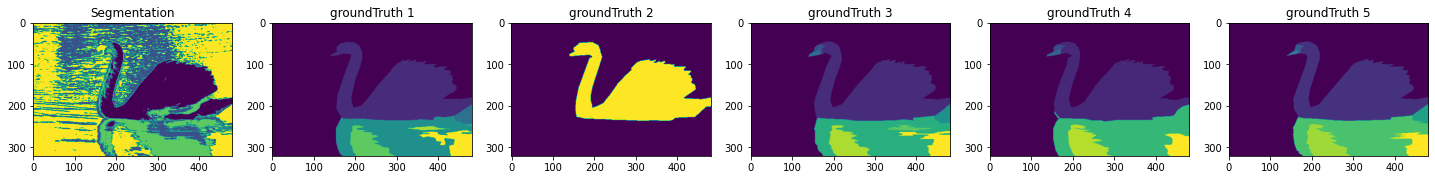

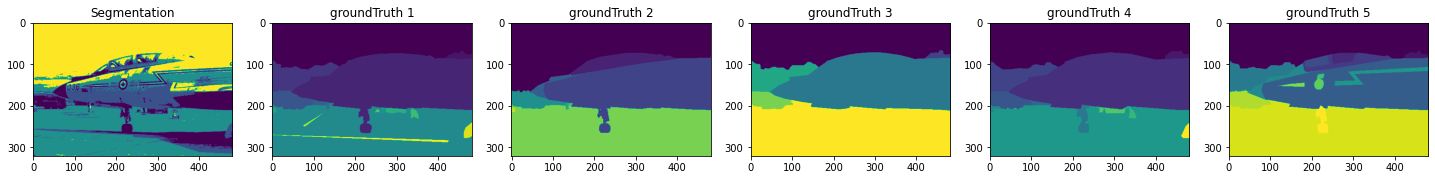

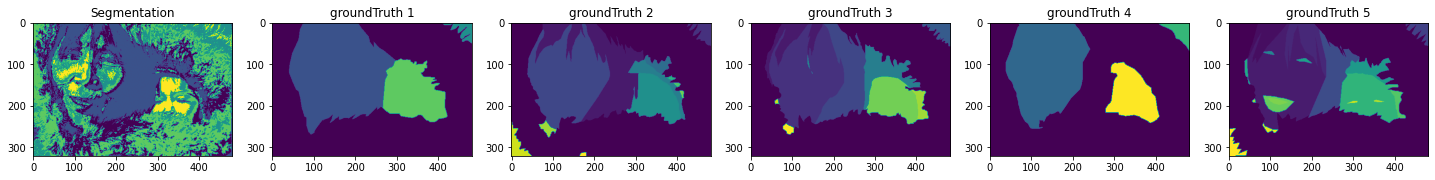

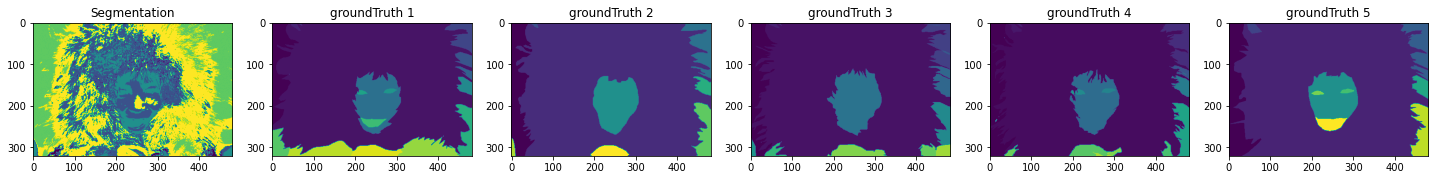

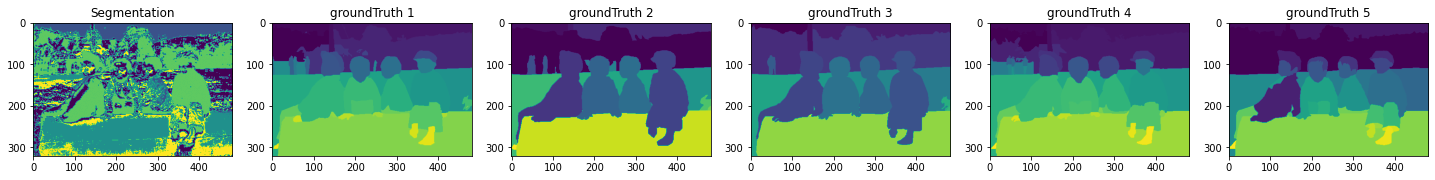

In [ ]:
for i in range(0,5):
  fig, axs = plt.subplots(1,6, figsize=(25,5))
  axs[0].imshow(output_implemented[i][1].reshape(321,481))
  axs[0].set_title("Segmentation")
  for j in range(1, 6) :
    axs[j].imshow(test_mat[i+4][j-1].reshape(321,481))
    axs[j].set_title("groundTruth "+ str(j))

**Resize Image**

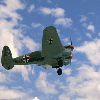

In [ ]:
img = test_jpg[1].reshape(321,481,3)
img = cv2.resize(img,(100,100))
cv2_imshow(img)

**Spectral Clustering**

In [ ]:
output_Ncut = []
for i in range(4,10):
  label =  normalized_cut(test_jpg[i])
  output_Ncut.append(label)

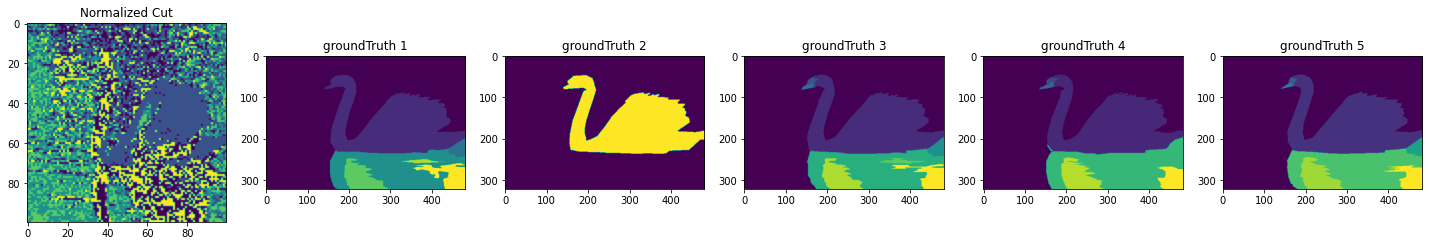

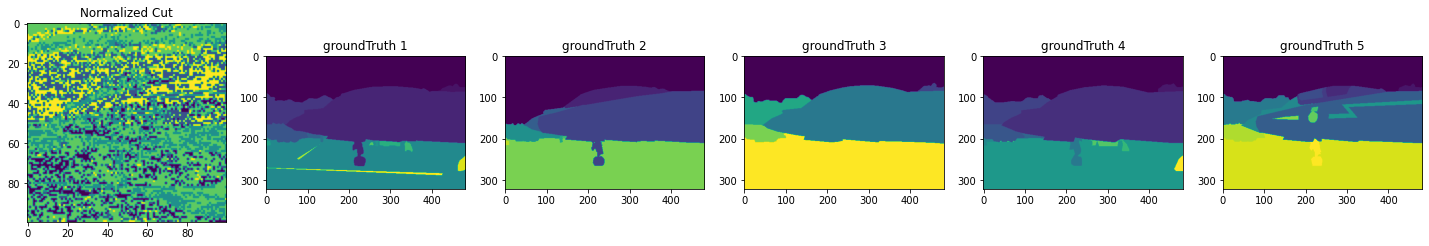

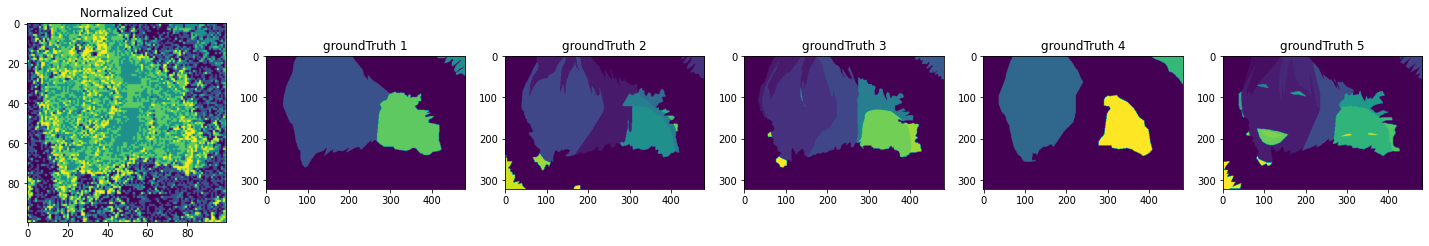

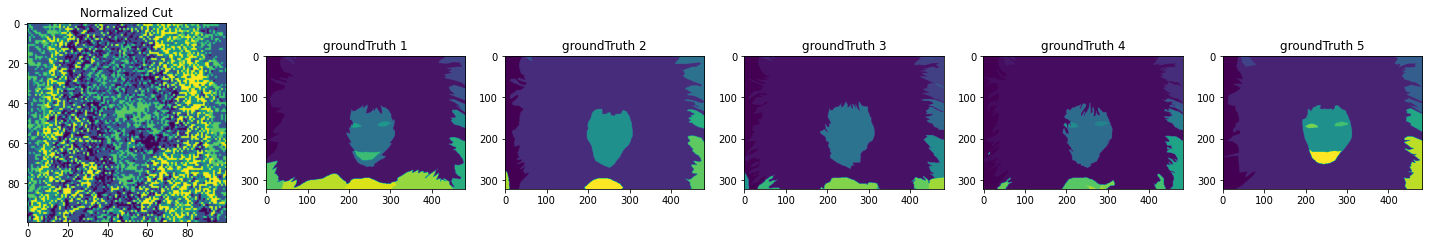

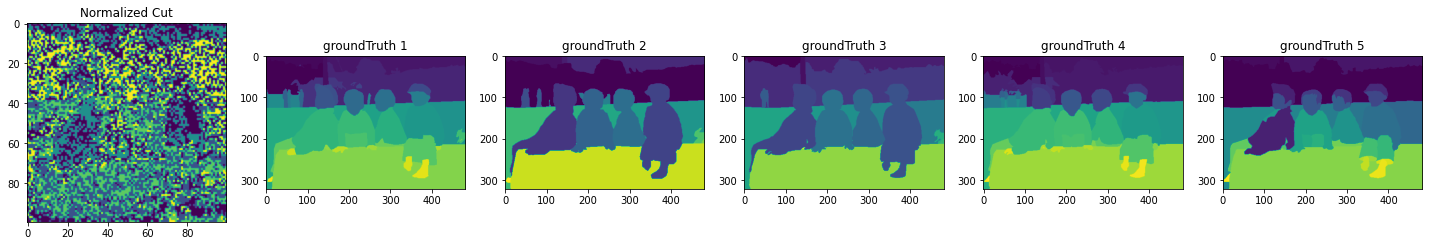

In [ ]:
for i in range(0,5):
  fig, axs = plt.subplots(1,6, figsize=(25,5))
  axs[0].imshow(output_Ncut[i].reshape(100,100))
  axs[0].set_title("Normalized Cut")
  for j in range(1, 6) :
    axs[j].imshow(test_mat[i+4][j-1].reshape(321,481))
    axs[j].set_title("groundTruth "+ str(j))

**K-Means VS Spectral Clustering**

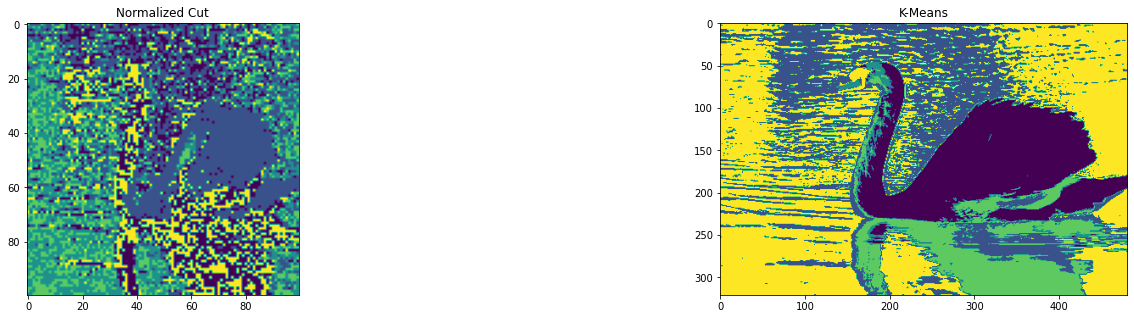

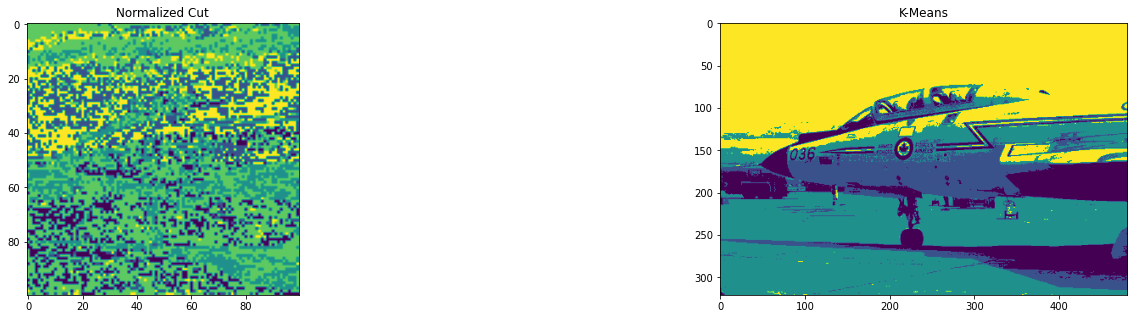

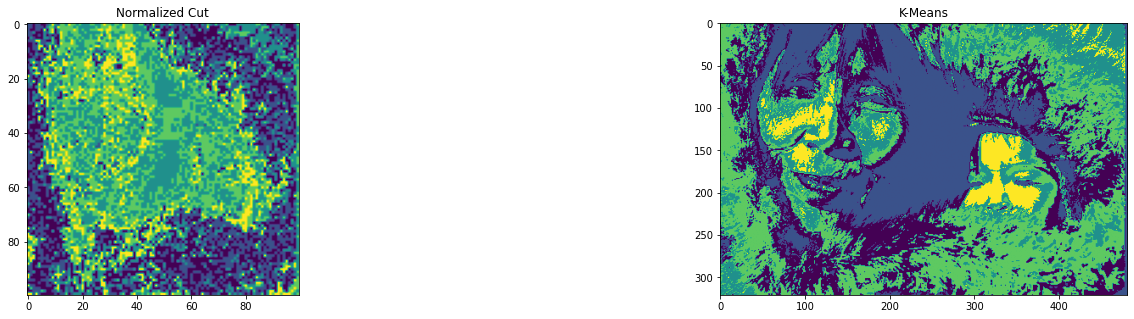

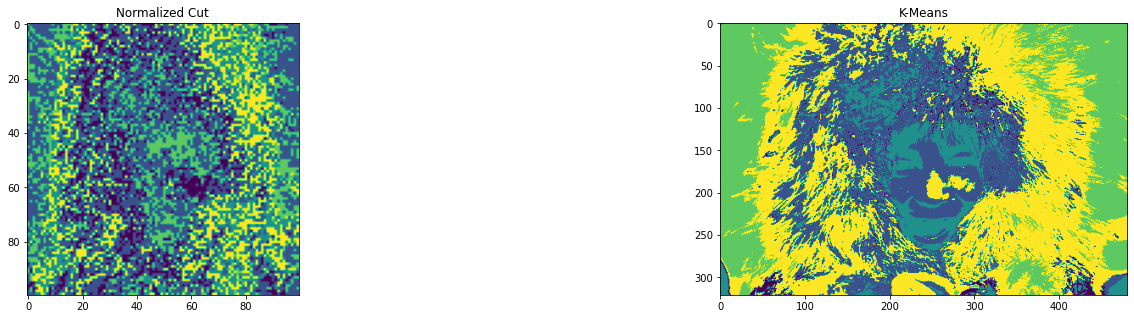

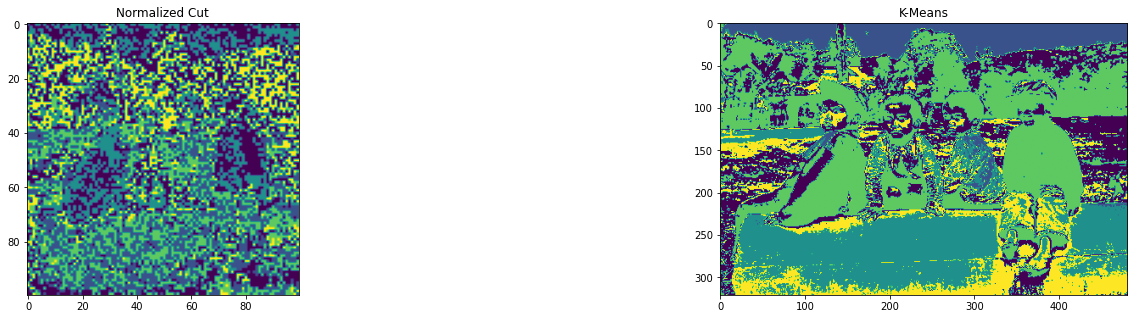

In [ ]:
for i in range(0,5):
  fig, axs = plt.subplots(1,2, figsize=(25,5))
  axs[0].imshow(output_Ncut[i].reshape(100,100))
  axs[0].set_title("Normalized Cut")
  axs[1].imshow(output_implemented[i][1].reshape(321,481))
  axs[1].set_title("K-Means")

**Bonus**

In [ ]:
modified_images = []
for i in range(4,10):
  image = test_jpg[i].reshape(321,481,3)
  modified = np.empty((321,481,5)) 
  for j in range(image.shape[0]):
    for k in range(image.shape[1]):
      position = [j,k]
      modified[j][k] = np.concatenate((image[j][k],position))
  modified_images.append(modified.reshape(321*481,5))
modified_images = np.array(modified_images)
modified_images.shape
modified_images = modified_images.reshape(6,321,481,5)

In [ ]:
k = [3,5,7,9,11]
output_bonus = []
for i in range(4,10):
  labels  = []
  for j in k:
    label = KMeans(n_clusters = j).fit(modified_images[i-4].reshape(321*481,5))
    labels.append(label.labels_)
  output_bonus.append(labels)

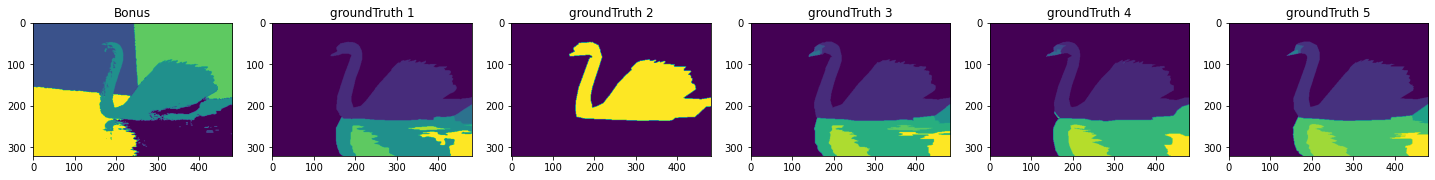

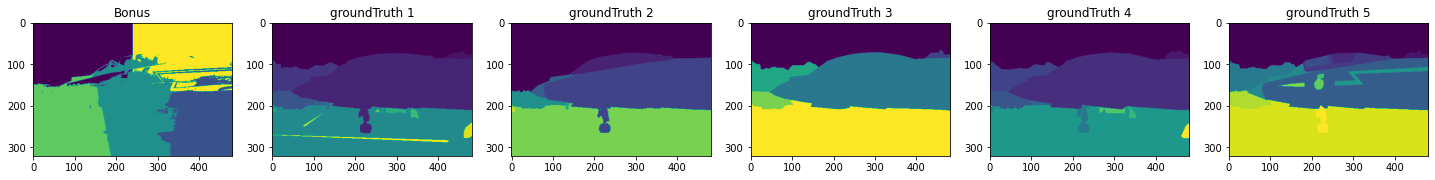

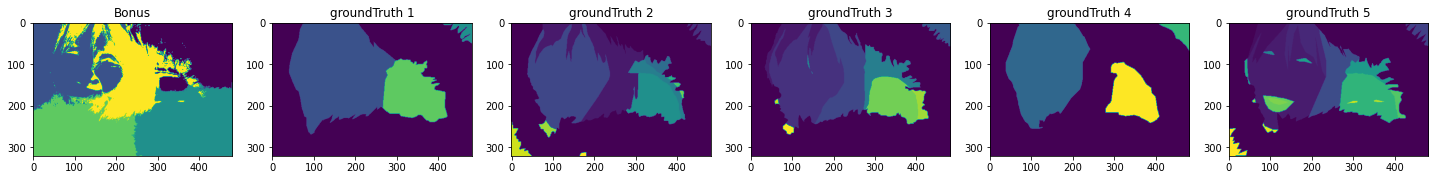

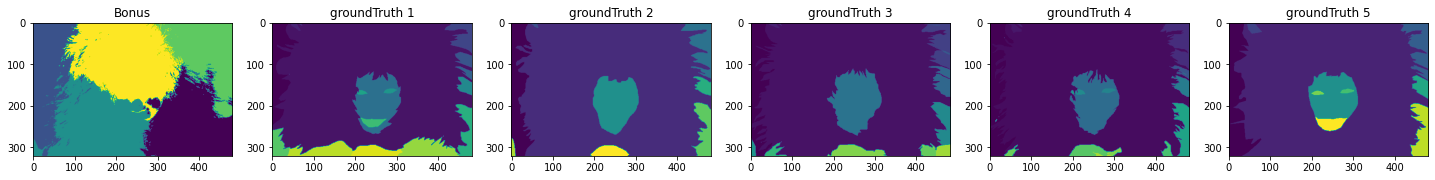

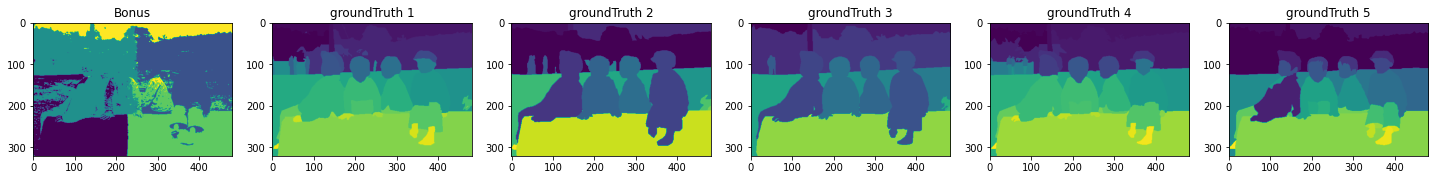

In [ ]:
for i in range(0,5):
  fig, axs = plt.subplots(1,6, figsize=(25,5))
  axs[0].imshow((np.array(output_bonus[i][1])).reshape(321,481))
  axs[0].set_title("Bonus")
  for j in range(1, 6) :
    axs[j].imshow(test_mat[i+4][j-1].reshape(321,481))
    axs[j].set_title("groundTruth "+ str(j))

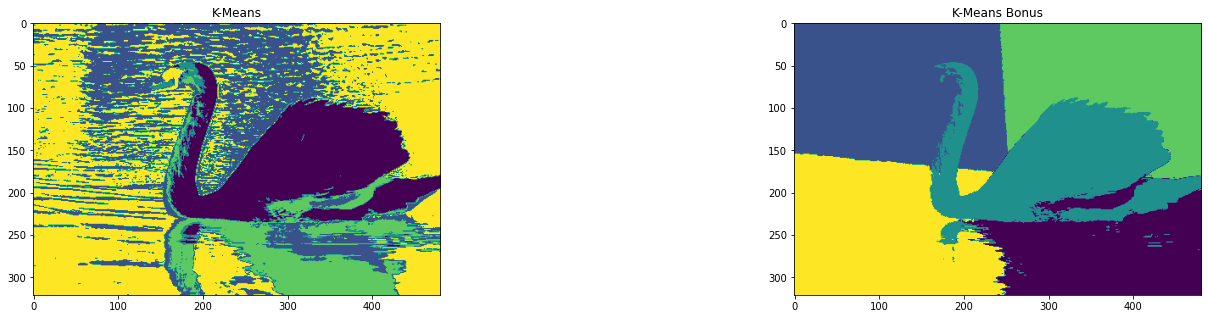

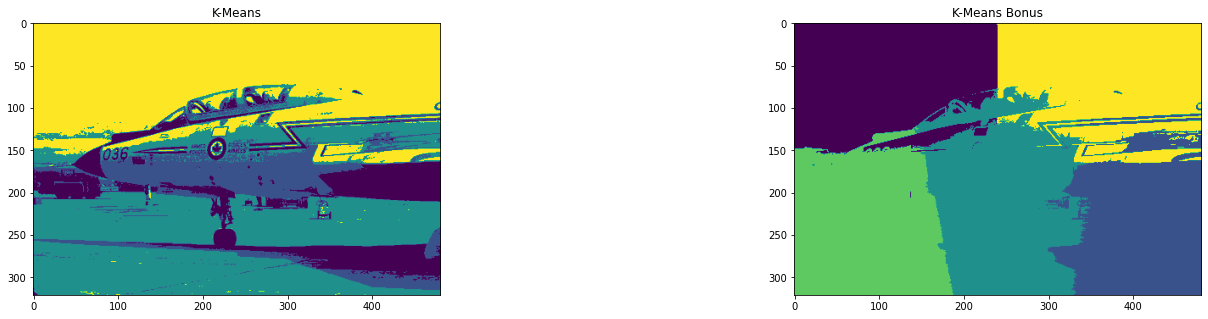

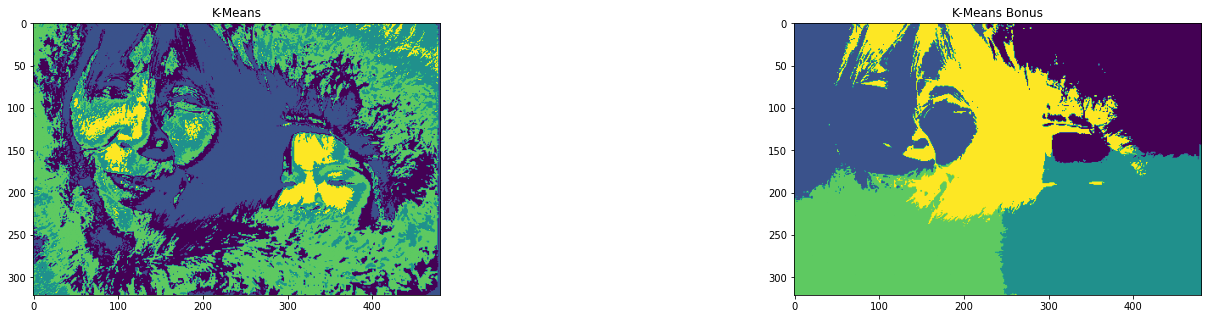

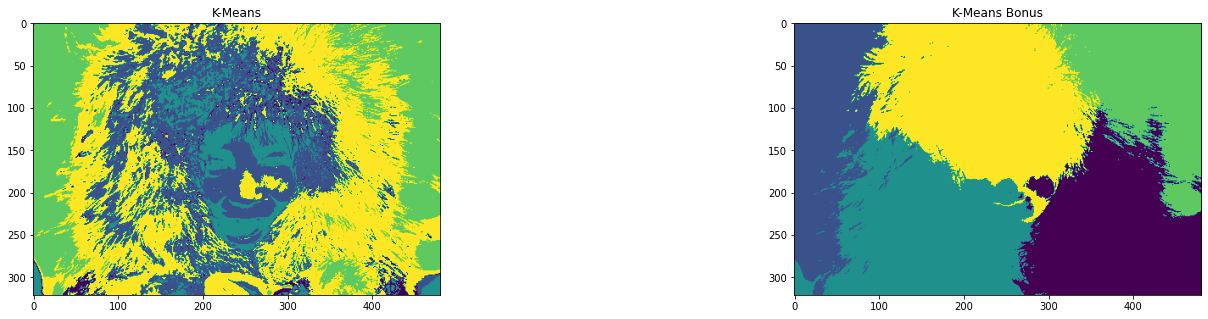

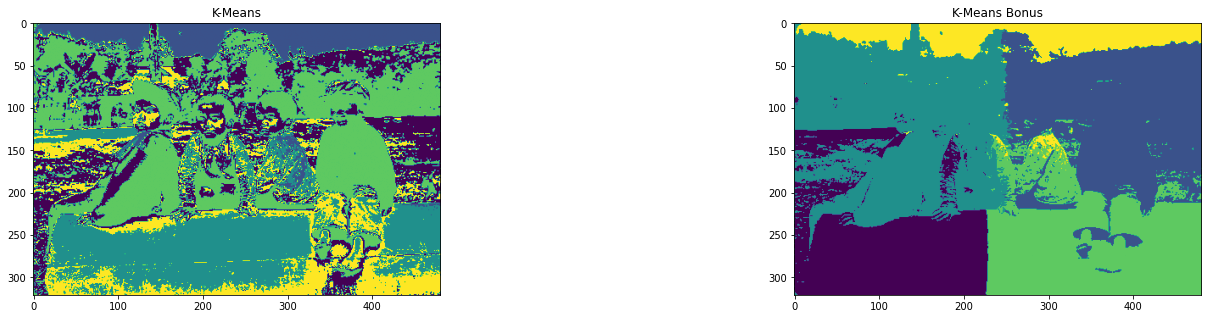

In [ ]:
for i in range(0,5):
  fig, axs = plt.subplots(1,2, figsize=(25,5))
  axs[0].imshow(output_implemented[i][1].reshape(321,481))
  axs[0].set_title("K-Means")
  axs[1].imshow((np.array(output_bonus[i][1])).reshape(321,481))
  axs[1].set_title("K-Means Bonus")

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Final Image Segmentation.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Final Image Segmentation.ipynb to pdf
[NbConvertApp] Support files will be in Final Image Segmentation_files/
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image Segmentation_files
[NbConvertApp] Making directory ./Final Image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'